# Hough Transform for Edge Detection
Jared Nielsen

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from scipy import ndimage, signal, stats

### Image Loading Notes
`cv2.imread()` loads in BGR, so you have to invert the color channel with `imread()[:,:,::-1]`.  
`mpimg.imread()` loads only a single color channel on grayscale images, while opencv loads all three. Depends what you want.

### Preprocessing Ideas
- Median filter
- Gaussian blur

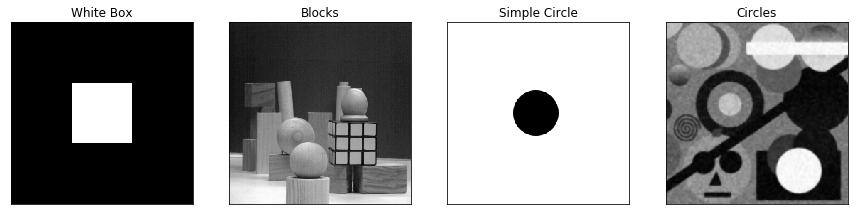

In [564]:
def color2gray(image):
    return 0.299 * image[:,:,0] + 0.587 * image[:,:,1] + 0.114 * image[:,:,2]

white_box = mpimg.imread("hough_images/2D_White_Box.png") # matplotlib 
blocks = mpimg.imread("hough_images/blocks.png")
simplecircle = color2gray(mpimg.imread("hough_images/simplecircle.png"))
circles = color2gray(cv2.imread("hough_images/circles.png")[:,:,::-1]) # for comparison
color_circles = cv2.imread("hough_images/circles.png")[:,:,::-1]
images = [white_box, blocks, simplecircle, circles]
grayscale = [True, True, False, False]

k = 5
scale = 1
circles = cv2.GaussianBlur(circles, ksize=(k,k), sigmaX=scale, sigmaY=scale)
color_circles = cv2.GaussianBlur(color_circles, ksize=(k,k), sigmaX=scale, sigmaY=scale)
circles = cv2.medianBlur(circles.astype(np.uint8), 3)
color_circles = cv2.medianBlur(color_circles, 3)

def plot_image(im, ax=None, title=None, gray=True):
    if not ax:
        ax = plt.subplots()[1]
    cmap = 'gray' if gray else None
    ax.imshow(im, cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])
    if title:
        ax.set_title(title)

fig, axs = plt.subplots(1, 4, figsize=(15,8))
plot_image(white_box, axs[0], "White Box")
plot_image(blocks, axs[1], "Blocks")
plot_image(simplecircle, axs[2], "Simple Circle")
plot_image(circles, axs[3], "Circles")

plt.show()

# Gradient Magnitude, Direction

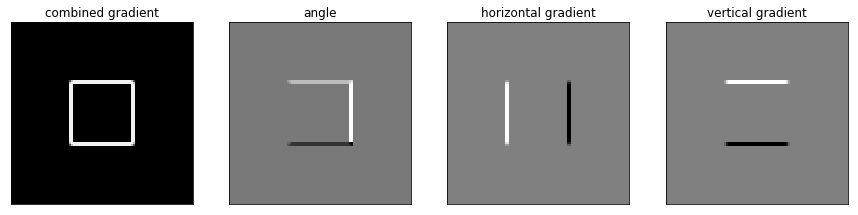

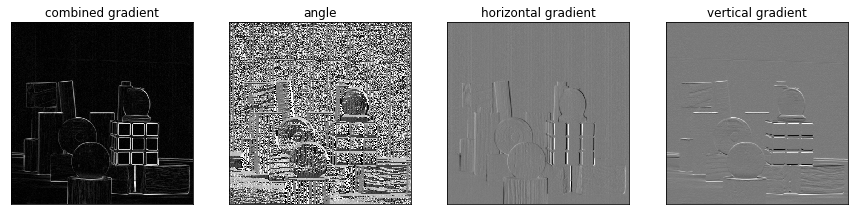

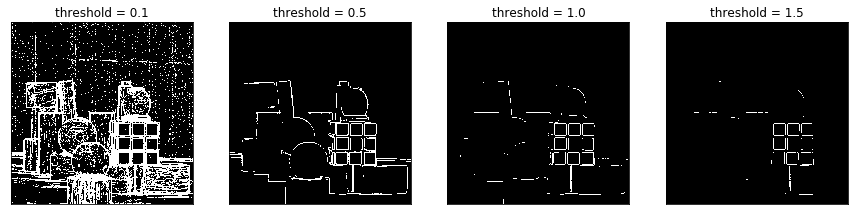

In [344]:
def gradient(image):
    """Uses a Sobel filter to calculate gradient magnitude."""
    kx = np.array([
        [1, 0, -1],
        [2, 0, -2],
        [1, 0, -1]
    ])
    ky = np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]
    ])
    Lx = signal.convolve2d(image, kx, mode='valid')
    Ly = signal.convolve2d(image, ky, mode='valid')
    
    magnitude = np.sqrt(Lx**2 + Ly**2)
    angle = np.arctan2(Ly, Lx) # arctan modifies the second argument in-place
    
    return magnitude, angle, Lx, Ly

def threshold(magnitude, thresh):
    return (magnitude > thresh).astype('uint8') * 255

# Plot gradient attributes for simple white box
fig, axs = plt.subplots(1, 4, figsize=(15,8))
mag, angle, Lx, Ly = gradient(white_box)
plot_image(mag, axs[0], title="combined gradient")
plot_image(angle, axs[1], title="angle")
plot_image(Lx, axs[2], title="horizontal gradient")
plot_image(Ly, axs[3], title="vertical gradient")
plt.show()

# Plot gradient attributes for complicated blocks
fig, axs = plt.subplots(1, 4, figsize=(15,8))
mag, angle, Lx, Ly = gradient(blocks)
plot_image(mag, axs[0], title="combined gradient")
plot_image(angle, axs[1], title="angle")
plot_image(Lx, axs[2], title="horizontal gradient")
plot_image(Ly, axs[3], title="vertical gradient")
plt.show()

# Plot potential thresholds for complicated blocks
fig, axs = plt.subplots(1, 4, figsize=(15,8))
mag, angle, Lx, Ly = gradient(blocks)
for i, thresh in enumerate([0.1, 0.5, 1.0, 1.5]):
    plot_image(threshold(mag, thresh), axs[i], title="threshold = {}".format(thresh))
plt.show()

So we choose 0.5 as a gradient magnitude threshold value.

# Laplacian Kernel and Zero Crossings

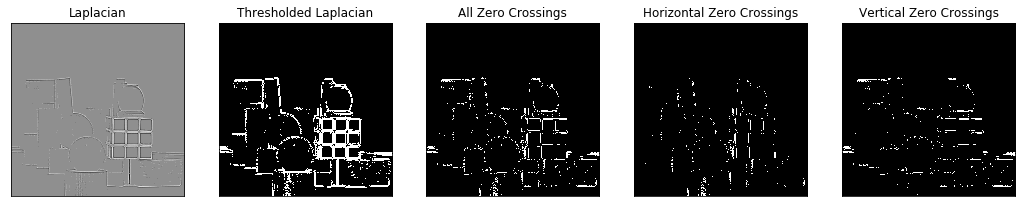

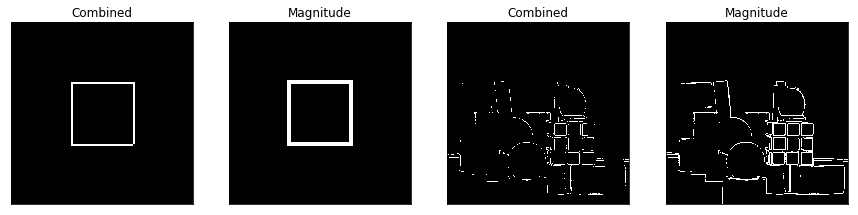

In [343]:
def laplacian(image, k=5, scale=1, thresh=0.01):
    """LoG filter with thresholding. Threshold the absolute value."""
    image = cv2.GaussianBlur(image, ksize=(k,k), sigmaX=scale, sigmaY=scale)
    kernel = np.array([
        [0, 1, 0],
        [1, -4, 1],
        [0, 1, 0]
    ])
#     kernel = np.array([
#         [1, 1, 1],
#         [1, -8, 1],
#         [1, 1, 1]
#     ])
    
    lap = signal.convolve2d(image, kernel, mode='valid')
    lap[np.bitwise_and(-thresh < lap, lap < thresh)] = 0    
    return lap

def zero_crossings(image, thresh=0.01):
    lap = laplacian(image, thresh=thresh)
    
    m, n = lap.shape
    horizontal_crossings = np.zeros_like(lap)
    vertical_crossings = np.zeros_like(lap)
    
    sign = 1
    for i in range(m):
        for j in range(n):
            if np.sign(lap[i,j]) == -sign:
                horizontal_crossings[i,j] = 1
                sign *= -1
                
    sign = 1
    for j in range(n):
        for i in range(m):
            if np.sign(lap[i,j]) == -sign:
                vertical_crossings[i,j] = 1
                sign *= -1
                
    fake_crossings = np.where(np.abs(lap) > thresh, 1, 0)
    total_crossings = horizontal_crossings + vertical_crossings - horizontal_crossings * vertical_crossings
    
    return lap, total_crossings, horizontal_crossings, vertical_crossings, fake_crossings

def edges(image, mag_thresh=0.5, lap_thresh=0):
    mag, angle, Lx, Ly = gradient(image)
    thresh = threshold(mag, thresh=mag_thresh)
    lap, tot_cross, x_cross, y_cross, f_cross = zero_crossings(image, thresh=lap_thresh)
    return thresh * tot_cross


    
lap, tot_cross, x_cross, y_cross, f_cross = zero_crossings(blocks, thresh=0.02)

fig, axs = plt.subplots(1, 5, figsize=(18,8))
plot_image(lap, axs[0], title="Laplacian")
plot_image(f_cross, axs[1], title="Thresholded Laplacian")
plot_image(tot_cross, axs[2], title="All Zero Crossings")
plot_image(x_cross, axs[3], title="Horizontal Zero Crossings")
plot_image(y_cross, axs[4], title="Vertical Zero Crossings")

fig, axs = plt.subplots(1, 4, figsize=(15,8))
plot_image(edges(white_box), axs[0], title="Combined")
plot_image(threshold(gradient(white_box)[0], 0.5), axs[1], title="Magnitude")
plot_image(edges(blocks), axs[2], title="Combined")
plot_image(threshold(gradient(blocks)[0], 0.5), axs[3], title="Magnitude")

# Circle Detection via Hough Transform
Include gradient orientation information? Inner product of gradient orientation and radius vector.
Expand outside image to get partial circles.  
Weight outside edges more as a ratio based on field of view.

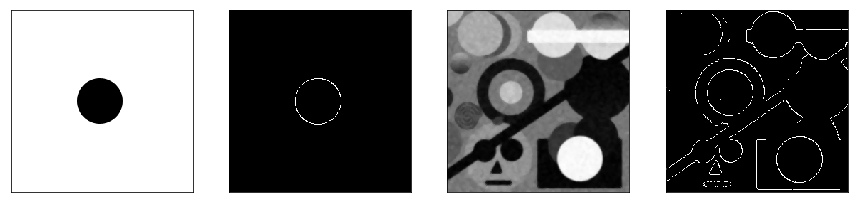

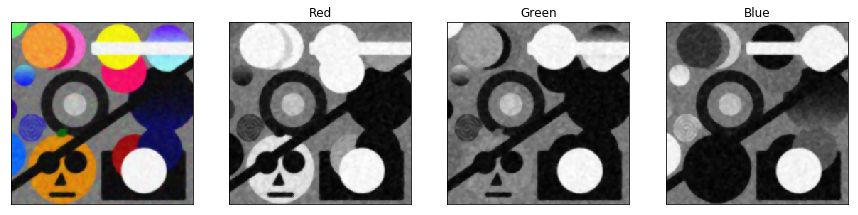

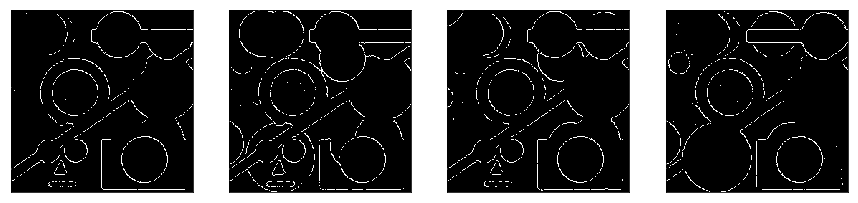

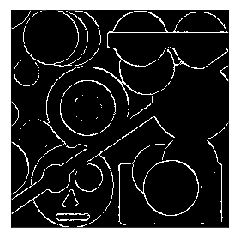

In [560]:
fig, axs = plt.subplots(1, 4, figsize=(15,8))
plot_image(simplecircle, axs[0])
plot_image(edges(simplecircle), axs[1])
plot_image(circles, axs[2])
plot_image(edges(circles, mag_thresh=200), axs[3])

fig, axs = plt.subplots(1, 4, figsize=(15,8))
axs[0].imshow(color_circles)
axs[0].set_xticks([])
axs[0].set_yticks([])
plot_image(color_circles[:,:,0], axs[1], title="Red")
plot_image(color_circles[:,:,1], axs[2], title="Green")
plot_image(color_circles[:,:,2], axs[3], title="Blue")

fig, axs = plt.subplots(1, 4, figsize=(15,8))
plot_image(edges(circles, mag_thresh=200), axs[0])
plot_image(edges(color_circles[:,:,0], mag_thresh=200), axs[1])
plot_image(edges(color_circles[:,:,1], mag_thresh=200), axs[2])
plot_image(edges(color_circles[:,:,2], mag_thresh=200), axs[3])

combined_edges = np.sum([ edges(color_circles[:,:,i], mag_thresh=200) for i in [0, 1, 2]], axis=0)
combined_edges = np.where(combined_edges > 0, 1, 0)
fig, ax = plt.subplots(1, 1)
plot_image(combined_edges, ax)

Here we compare our channel-wise edge detection with Canny edge detection. Notice that the blurring has nearly removed the spiral, and the orange pumpkin is quite visible.

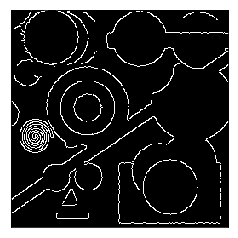

In [528]:
canny_edges = cv2.Canny(np.uint8(circles), 100, 200)
plot_image(canny_edges)

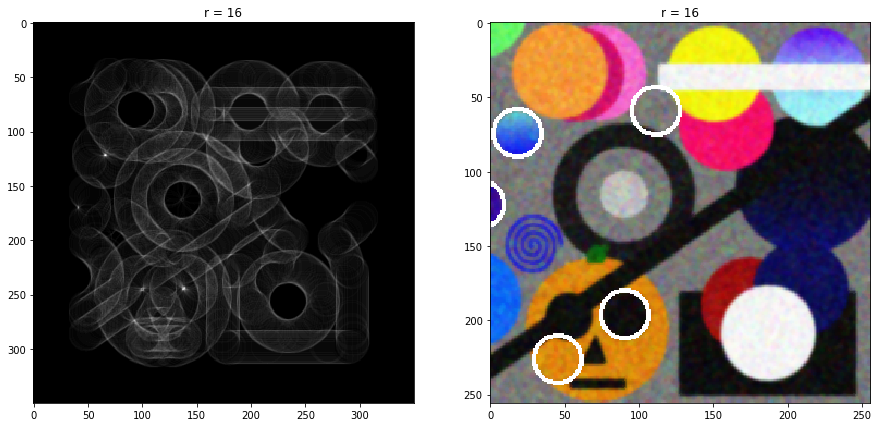

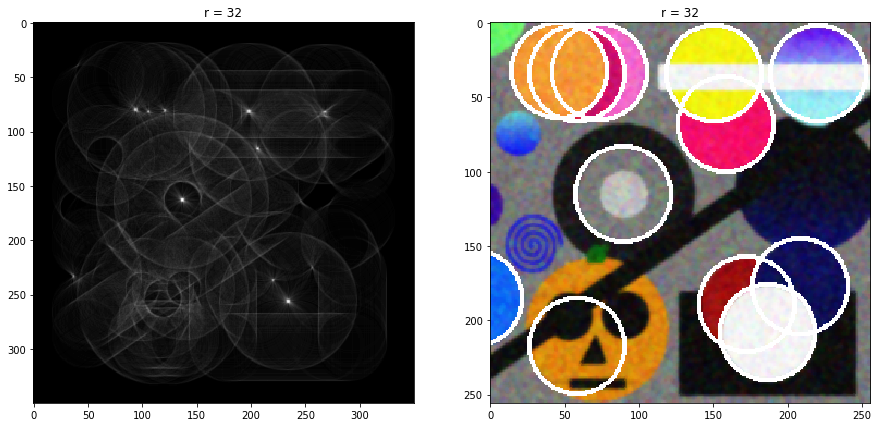

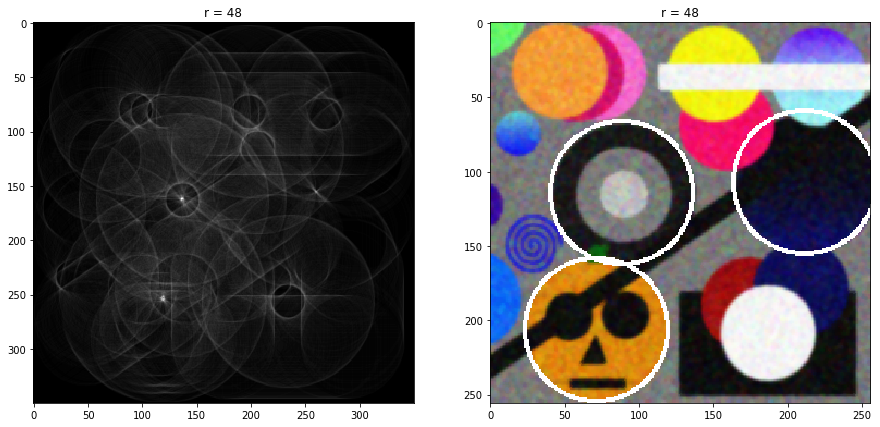

In [568]:
def hough_circle_accumulator(edges, rs):
    """Finds circles in the image space, corresponding to local maxima in the accumulator space."""
    r_max = np.max(rs)
    m, n = edges.shape
    ml, nl = m + 2 * r_max, n + 2 * r_max # expand the image dimensions
    edges_expanded = np.zeros((ml,nl))
    edges_expanded[r_max:-r_max,r_max:-r_max] = edges
    
    # Construct a larger array containing the image and an additional border
    # Circle centers can lie outside the image.
    acc = np.zeros((len(rs), ml, nl))# contains potential circle centers
    
    # Template matching for circles of various sizes
    templates = [
        np.zeros((2 * r + 1, 2 * r + 1))
        for r in rs
    ]
    for i, r in enumerate(rs):
        for theta in np.linspace(0, 2 * np.pi, 20 * r_max):
            x = r + int(r * np.cos(theta))
            y = r + int(r * np.sin(theta))
            templates[i][x,y] = 1
            
    convs = [
        signal.convolve2d(edges_expanded, template, mode='same')
        for template in templates
    ]
    
    # Handle edge cases where the circle center is outside the image.
    # We want to scale by 2π/θ, where θ is the angle length that lies inside the image.
    # We approximate θ by 2 * arccos(d/r), where d is the distance to the image edge and r is the radius.
    for r, conv in zip(rs, convs):
        for i in range(r_max - r // 2, 2 * r_max):
            d = r_max - i
#             factor = min(2, (np.pi / np.arccos(np.clip(d / r, -1, 0.5)) - 1) / 2 + 1)
            factor = np.pi / np.arccos(np.clip(d / r, -1, 0.5)) # circle center must be at least 1/2 radius away
#             factor = 1
            
            # upper rows
#             conv[i,:] *= factor
            # lower rows
#             conv[-i,:] *= factor
            # left columns
#             conv[:,i] *= factor
            # right columns
#             conv[:,-i] *= factor
    
    return convs
        
def clip(idx):
    return int(max(idx,0))

def hough_peaks(im, n_peaks, thresh, nhood_size, r_max):
    peaks = np.zeros((n_peaks,2))
    im_temp = im.copy()
    
    for i in range(n_peaks):
        max_loc = np.unravel_index(np.argmax(im_temp), im_temp.shape)
        max_val = im[max_loc]
        if max_val > thresh:
            peaks[i] = max_loc - r_max
            r, c = max_loc
            t = nhood_size//2.0
            im_temp[clip(r-t):int(r+t+1), clip(c-t):int(c+t+1)] = 0
        else:
            peaks = peaks[:i]
            break
        
    return peaks

def plot_peaks(im, r, peaks):
    im = im.copy()
    for peak in peaks:
        s = int(np.max(im))
        cv2.circle(img=im, center=(int(peak[1]), int(peak[0])), radius=r, color=(s,s,s), thickness=2)
    return im

rs = [16, 32, 48]
acc = hough_circle_accumulator(combined_edges, rs)



for a, r, n_circles in zip(acc, rs, [5, 12, 3]):
    a_marked = a.copy()
    peaks = hough_peaks(a, n_circles, thresh=0, nhood_size=16, r_max=np.max(rs))
    a_marked = plot_peaks(color_circles, r=r, peaks=peaks)
    fig, axs = plt.subplots(1, 2, figsize=(15,8))
    axs[0].imshow(a, cmap='gray')
    axs[0].set_title("r = {}".format(r))
    axs[1].imshow(a_marked)
    axs[1].set_title("r = {}".format(r))
    plt.show()